In [1]:
import pandas as pd
import numpy as np
from rfpimp import *
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, roc_curve, precision_score, recall_score
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


#### Importing and cleaning CDC and CHR data sets

In [2]:
cdc_df = pd.read_csv('data/CDC_Data.csv')

In [3]:
chr_df = pd.read_csv('data/CHR_Data.csv')

In [4]:
cdc_df

,FIPS,STATE,ST_ABBR,COUNTY,AREA_SQMI,E_TOTPOP,Pop_Dens,perc_below_pov,perc_unemp,perc_65o,perc_17y,perc_disabled,perc_minority,perc_lim_eng,percent_multiunit_housing,perc_overcrowded,perc_no_vehicle,perc_group_quarters,perc_uninsured
0,35039,NEW MEXICO,NM,Rio Arriba,5860.869195,39307,6.706684,NaN,NaN,18.0,23.7,16.1,87.5,2.1,0.3,2.1,6.2,1.7,10.6
1,1001,ALABAMA,AL,Autauga,594.443459,55200,92.859967,15.4,4.2,14.6,24.2,19.3,25.0,0.8,3.8,1.4,5.6,1.0,7.1
2,1009,ALABAMA,AL,Blount,644.830460,57645,89.395591,14.4,4.1,17.8,23.4,14.2,12.9,1.7,0.9,1.6,4.2,0.9,11.0
3,1013,ALABAMA,AL,Butler,776.838201,20025,25.777569,23.5,6.7,19.0,22.8,17.7,48.1,0.5,1.3,1.8,7.8,1.6,10.2
4,1015,ALABAMA,AL,Calhoun,605.867251,115098,189.972308,18.6,8.8,16.8,21.9,20.8,27.5,1.0,3.7,1.7,5.8,2.7,9.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,48131,TEXAS,TX,Duval,1793.476183,11355,6.331280,25.6,10.6,17.8,26.1,26.2,90.9,5.7,0.5,7.4,10.0,4.4,24.5
3138,48505,TEXAS,TX,Zapata,998.411980,14369,14.391855,39.5,11.0,13.9,33.6,17.3,95.7,24.4,0.6,18.1,7.9,0.2,29.3
3139,48507,TEXAS,TX,Zavala,1297.406535,12131,9.350192,34.8,8.4,13.7,29.5,23.3,95.0,8.0,1.7,5.6,14.4,1.6,18.4
3140,48127,TEXAS,TX,Dimmit,1328.884075,10663,8.024026,29.8,16.4,16.3,30.0,23.0,90.5,8.0,3.8,8.5,11.9,1.2,22.2


In [5]:
state_county_df = cdc_df[['FIPS', 'STATE', 'ST_ABBR', 'COUNTY']]

In [6]:
state_county_df = state_county_df.sort_values('FIPS')

In [7]:
state_county_df.to_csv('data/fips.csv', index = False)

In [8]:
cdc_df.drop(columns = ['STATE', 'ST_ABBR', 'COUNTY', 'AREA_SQMI', 'E_TOTPOP'], inplace = True)

In [9]:
cdc_df

,FIPS,Pop_Dens,perc_below_pov,perc_unemp,perc_65o,perc_17y,perc_disabled,perc_minority,perc_lim_eng,percent_multiunit_housing,perc_overcrowded,perc_no_vehicle,perc_group_quarters,perc_uninsured
0,35039,6.706684,NaN,NaN,18.0,23.7,16.1,87.5,2.1,0.3,2.1,6.2,1.7,10.6
1,1001,92.859967,15.4,4.2,14.6,24.2,19.3,25.0,0.8,3.8,1.4,5.6,1.0,7.1
2,1009,89.395591,14.4,4.1,17.8,23.4,14.2,12.9,1.7,0.9,1.6,4.2,0.9,11.0
3,1013,25.777569,23.5,6.7,19.0,22.8,17.7,48.1,0.5,1.3,1.8,7.8,1.6,10.2
4,1015,189.972308,18.6,8.8,16.8,21.9,20.8,27.5,1.0,3.7,1.7,5.8,2.7,9.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,48131,6.331280,25.6,10.6,17.8,26.1,26.2,90.9,5.7,0.5,7.4,10.0,4.4,24.5
3138,48505,14.391855,39.5,11.0,13.9,33.6,17.3,95.7,24.4,0.6,18.1,7.9,0.2,29.3
3139,48507,9.350192,34.8,8.4,13.7,29.5,23.3,95.0,8.0,1.7,5.6,14.4,1.6,18.4
3140,48127,8.024026,29.8,16.4,16.3,30.0,23.0,90.5,8.0,3.8,8.5,11.9,1.2,22.2


In [10]:
chr_df

,FIPS,State,County,perc_fair_poor_health,perc_smokers,perc_obese,perc_phys_inactive,perc_uninsured,pcp_rate,other_pcp_rate,...,perc_65_up,perc_afr_am,perc_nat_am_as,perc_asian,perc_nh_opi,perc_hisp,perc_nonhisp_white,perc_not_eng_prof,perc_fem,perc_rural
0,1001,Alabama,Autauga,18,19,36,31,9.0,45.0,29.0,...,14.7,19.0,0.5,1.1,0.1,2.7,75.0,0.8,51.3,42.0
1,1003,Alabama,Baldwin,18,17,29,25,12.0,73.0,44.0,...,19.7,9.0,0.8,1.1,0.1,4.4,83.2,0.8,51.5,42.3
2,1005,Alabama,Barbour,26,22,44,31,13.0,42.0,27.0,...,18.0,47.5,0.6,0.5,0.2,4.2,46.5,1.5,46.9,67.8
3,1007,Alabama,Bibb,20,20,38,38,12.0,53.0,75.0,...,15.4,21.6,0.4,0.2,0.1,2.5,74.4,0.4,46.4,68.4
4,1009,Alabama,Blount,21,20,36,29,14.0,21.0,12.0,...,18.0,1.4,0.6,0.3,0.1,9.1,87.5,1.9,50.6,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,Wyoming,Sweetwater,15,18,31,26,12.0,34.0,54.0,...,10.5,1.1,1.5,0.8,0.2,16.1,79.6,2.1,48.2,10.9
3138,56039,Wyoming,Teton,12,14,13,12,15.0,121.0,108.0,...,13.5,0.6,0.9,1.2,0.1,15.1,81.5,3.6,48.4,46.4
3139,56041,Wyoming,Uinta,16,18,32,25,12.0,43.0,63.0,...,12.6,0.7,1.3,0.6,0.2,9.0,87.5,1.3,49.4,43.1
3140,56043,Wyoming,Washakie,16,16,27,25,17.0,36.0,61.0,...,20.9,0.5,1.7,0.8,0.1,13.9,82.6,0.7,49.7,36.0


In [11]:
chr_df.drop(columns = ['State', 'County'], inplace = True)

In [12]:
chr_df['pcp_rate_100k'] = (chr_df['pcp_rate']+chr_df['other_pcp_rate'])

In [13]:
chr_df.drop(columns = ['pcp_rate', 'other_pcp_rate'], inplace = True)

In [14]:
chr_df.rename(columns = {'perc_uninsured':'perc_unins'}, inplace = True)

In [15]:
cdc_df.columns

Index(['FIPS', 'Pop_Dens', 'perc_below_pov', 'perc_unemp', 'perc_65o',
       'perc_17y', 'perc_disabled', 'perc_minority', 'perc_lim_eng',
       'percent_multiunit_housing', 'perc_overcrowded', 'perc_no_vehicle',
       'perc_group_quarters', 'perc_uninsured'],
      dtype='object')

In [16]:
chr_df.columns

Index(['FIPS', 'perc_fair_poor_health', 'perc_smokers', 'perc_obese',
       'perc_phys_inactive', 'perc_unins', 'prev_hosp_rate_medicare',
       'perc_unemployed', 'air_pollution', 'age_adjusted_mortality',
       'perc_diab', 'perc_insuf_sleep', 'health_costs', 'med_house_income',
       'bw_seg', 'wnw_seg', 'Population', 'perc_18_down', 'perc_65_up',
       'perc_afr_am', 'perc_nat_am_as', 'perc_asian', 'perc_nh_opi',
       'perc_hisp', 'perc_nonhisp_white', 'perc_not_eng_prof', 'perc_fem',
       'perc_rural', 'pcp_rate_100k'],
      dtype='object')

#### Merging CDC and CHR dataframes in one sociohealth dataframe (and more cleaning)

In [17]:
df_sociohealth = pd.merge(cdc_df, chr_df, how='inner', on = 'FIPS')

In [18]:
df_sociohealth.columns

Index(['FIPS', 'Pop_Dens', 'perc_below_pov', 'perc_unemp', 'perc_65o',
       'perc_17y', 'perc_disabled', 'perc_minority', 'perc_lim_eng',
       'percent_multiunit_housing', 'perc_overcrowded', 'perc_no_vehicle',
       'perc_group_quarters', 'perc_uninsured', 'perc_fair_poor_health',
       'perc_smokers', 'perc_obese', 'perc_phys_inactive', 'perc_unins',
       'prev_hosp_rate_medicare', 'perc_unemployed', 'air_pollution',
       'age_adjusted_mortality', 'perc_diab', 'perc_insuf_sleep',
       'health_costs', 'med_house_income', 'bw_seg', 'wnw_seg', 'Population',
       'perc_18_down', 'perc_65_up', 'perc_afr_am', 'perc_nat_am_as',
       'perc_asian', 'perc_nh_opi', 'perc_hisp', 'perc_nonhisp_white',
       'perc_not_eng_prof', 'perc_fem', 'perc_rural', 'pcp_rate_100k'],
      dtype='object')

In [19]:
df_sociohealth['65_older'] = ((df_sociohealth['perc_65o']+df_sociohealth['perc_65_up'])/2)

In [20]:
df_sociohealth['17_younger'] = ((df_sociohealth['perc_17y']+df_sociohealth['perc_18_down'])/2)

In [21]:
df_sociohealth.drop(columns = ['perc_65o', 'perc_65_up', 'perc_17y', 'perc_18_down' ], inplace = True)

In [22]:
df_sociohealth

,FIPS,Pop_Dens,perc_below_pov,perc_unemp,perc_disabled,perc_minority,perc_lim_eng,percent_multiunit_housing,perc_overcrowded,perc_no_vehicle,...,perc_asian,perc_nh_opi,perc_hisp,perc_nonhisp_white,perc_not_eng_prof,perc_fem,perc_rural,pcp_rate_100k,65_older,17_younger
0,35039,6.706684,NaN,NaN,16.1,87.5,2.1,0.3,2.1,6.2,...,0.6,0.2,70.8,12.7,2.7,51.1,49.8,136.0,17.90,23.95
1,1001,92.859967,15.4,4.2,19.3,25.0,0.8,3.8,1.4,5.6,...,1.1,0.1,2.7,75.0,0.8,51.3,42.0,74.0,14.65,24.30
2,1009,89.395591,14.4,4.1,14.2,12.9,1.7,0.9,1.6,4.2,...,0.3,0.1,9.1,87.5,1.9,50.6,90.0,33.0,17.90,23.30
3,1013,25.777569,23.5,6.7,17.7,48.1,0.5,1.3,1.8,7.8,...,1.1,0.1,1.3,52.2,0.9,53.4,71.2,90.0,19.00,23.20
4,1015,189.972308,18.6,8.8,20.8,27.5,1.0,3.7,1.7,5.8,...,0.9,0.1,3.6,72.6,0.7,51.9,33.7,116.0,16.85,21.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,48131,6.331280,25.6,10.6,26.2,90.9,5.7,0.5,7.4,10.0,...,0.4,0.1,89.4,9.0,4.9,48.7,67.0,NaN,17.85,25.95
3138,48505,14.391855,39.5,11.0,17.3,95.7,24.4,0.6,18.1,7.9,...,0.2,0.0,94.6,4.8,25.6,50.2,23.5,28.0,12.90,33.60
3139,48507,9.350192,34.8,8.4,23.3,95.0,8.0,1.7,5.6,14.4,...,0.2,0.2,93.6,5.6,9.9,49.8,38.0,92.0,13.50,29.80
3140,48127,8.024026,29.8,16.4,23.0,90.5,8.0,3.8,8.5,11.9,...,0.7,0.0,86.6,11.3,7.4,51.0,39.5,92.0,15.75,29.95


In [23]:
df_sociohealth['uninsured'] = ((df_sociohealth['perc_uninsured']+df_sociohealth['perc_unins'])/2)

In [24]:
df_sociohealth.drop(columns = ['perc_uninsured', 'perc_unins' ], inplace = True)

In [25]:
df_sociohealth['lim_eng'] = ((df_sociohealth['perc_lim_eng']+df_sociohealth['perc_not_eng_prof'])/2)

In [26]:
df_sociohealth.drop(columns = ['perc_lim_eng', 'perc_not_eng_prof' ], inplace = True)

In [27]:
df_sociohealth['unemployed'] = ((df_sociohealth['perc_unemployed']+df_sociohealth['perc_unemp'])/2)

In [28]:
df_sociohealth.drop(columns = ['perc_unemployed', 'perc_unemp' ], inplace = True)

In [29]:
df_sociohealth

,FIPS,Pop_Dens,perc_below_pov,perc_disabled,perc_minority,percent_multiunit_housing,perc_overcrowded,perc_no_vehicle,perc_group_quarters,perc_fair_poor_health,...,perc_hisp,perc_nonhisp_white,perc_fem,perc_rural,pcp_rate_100k,65_older,17_younger,uninsured,lim_eng,unemployed
0,35039,6.706684,NaN,16.1,87.5,0.3,2.1,6.2,1.7,27,...,70.8,12.7,51.1,49.8,136.0,17.90,23.95,12.80,2.40,NaN
1,1001,92.859967,15.4,19.3,25.0,3.8,1.4,5.6,1.0,18,...,2.7,75.0,51.3,42.0,74.0,14.65,24.30,8.05,0.80,4.75
2,1009,89.395591,14.4,14.2,12.9,0.9,1.6,4.2,0.9,21,...,9.1,87.5,50.6,90.0,33.0,17.90,23.30,12.50,1.80,4.80
3,1013,25.777569,23.5,17.7,48.1,1.3,1.8,7.8,1.6,27,...,1.3,52.2,53.4,71.2,90.0,19.00,23.20,11.10,0.70,6.90
4,1015,189.972308,18.6,20.8,27.5,3.7,1.7,5.8,2.7,20,...,3.6,72.6,51.9,33.7,116.0,16.85,21.85,10.20,0.85,7.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,48131,6.331280,25.6,26.2,90.9,0.5,7.4,10.0,4.4,32,...,89.4,9.0,48.7,67.0,NaN,17.85,25.95,22.25,5.30,10.85
3138,48505,14.391855,39.5,17.3,95.7,0.6,18.1,7.9,0.2,35,...,94.6,4.8,50.2,23.5,28.0,12.90,33.60,29.15,25.00,11.00
3139,48507,9.350192,34.8,23.3,95.0,1.7,5.6,14.4,1.6,40,...,93.6,5.6,49.8,38.0,92.0,13.50,29.80,19.20,8.95,11.25
3140,48127,8.024026,29.8,23.0,90.5,3.8,8.5,11.9,1.2,31,...,86.6,11.3,51.0,39.5,92.0,15.75,29.95,20.10,7.70,11.80


In [30]:
df_sociohealth.columns

Index(['FIPS', 'Pop_Dens', 'perc_below_pov', 'perc_disabled', 'perc_minority',
       'percent_multiunit_housing', 'perc_overcrowded', 'perc_no_vehicle',
       'perc_group_quarters', 'perc_fair_poor_health', 'perc_smokers',
       'perc_obese', 'perc_phys_inactive', 'prev_hosp_rate_medicare',
       'air_pollution', 'age_adjusted_mortality', 'perc_diab',
       'perc_insuf_sleep', 'health_costs', 'med_house_income', 'bw_seg',
       'wnw_seg', 'Population', 'perc_afr_am', 'perc_nat_am_as', 'perc_asian',
       'perc_nh_opi', 'perc_hisp', 'perc_nonhisp_white', 'perc_fem',
       'perc_rural', 'pcp_rate_100k', '65_older', '17_younger', 'uninsured',
       'lim_eng', 'unemployed'],
      dtype='object')

In [31]:
df_sociohealth = df_sociohealth.sort_values(by = "FIPS")

In [32]:
df_sociohealth.isnull().sum()

FIPS                            0
Pop_Dens                        0
perc_below_pov                  1
perc_disabled                   0
perc_minority                   0
percent_multiunit_housing       0
perc_overcrowded                0
perc_no_vehicle                 0
perc_group_quarters             0
perc_fair_poor_health           0
perc_smokers                    0
perc_obese                      0
perc_phys_inactive              0
prev_hosp_rate_medicare       122
air_pollution                  34
age_adjusted_mortality         65
perc_diab                       0
perc_insuf_sleep                0
health_costs                    7
med_house_income                1
bw_seg                       1091
wnw_seg                       356
Population                      0
perc_afr_am                     0
perc_nat_am_as                  0
perc_asian                      0
perc_nh_opi                     0
perc_hisp                       0
perc_nonhisp_white              0
perc_fem      

In [33]:
df_sociohealth.drop(columns = 'bw_seg', inplace = True)

In [34]:
column_list = ['perc_below_pov', 'unemployed','prev_hosp_rate_medicare', 'air_pollution',
               'age_adjusted_mortality','health_costs', 'med_house_income', 'wnw_seg', 'perc_rural',
               'pcp_rate_100k', 'uninsured']

In [35]:
for column in column_list: 
    df_sociohealth[column].fillna(df_sociohealth[column].mean(skipna = True), inplace = True)

In [36]:
df_sociohealth.columns

Index(['FIPS', 'Pop_Dens', 'perc_below_pov', 'perc_disabled', 'perc_minority',
       'percent_multiunit_housing', 'perc_overcrowded', 'perc_no_vehicle',
       'perc_group_quarters', 'perc_fair_poor_health', 'perc_smokers',
       'perc_obese', 'perc_phys_inactive', 'prev_hosp_rate_medicare',
       'air_pollution', 'age_adjusted_mortality', 'perc_diab',
       'perc_insuf_sleep', 'health_costs', 'med_house_income', 'wnw_seg',
       'Population', 'perc_afr_am', 'perc_nat_am_as', 'perc_asian',
       'perc_nh_opi', 'perc_hisp', 'perc_nonhisp_white', 'perc_fem',
       'perc_rural', 'pcp_rate_100k', '65_older', '17_younger', 'uninsured',
       'lim_eng', 'unemployed'],
      dtype='object')

**Creating a separate df with race percentages by county. Not sure if I want to use these but would like to be able to merge them all at once in case I do**

In [37]:
df_race = df_sociohealth[['FIPS','perc_afr_am', 'perc_nat_am_as',
       'perc_asian', 'perc_nh_opi', 'perc_hisp', 'perc_nonhisp_white']]

In [38]:
df_race.reset_index(inplace = True)
df_race

,index,FIPS,perc_afr_am,perc_nat_am_as,perc_asian,perc_nh_opi,perc_hisp,perc_nonhisp_white
0,1,1001,19.0,0.5,1.1,0.1,2.7,75.0
1,1315,1003,9.0,0.8,1.1,0.1,4.4,83.2
2,3076,1005,47.5,0.6,0.5,0.2,4.2,46.5
3,2130,1007,21.6,0.4,0.2,0.1,2.5,74.4
4,2,1009,1.4,0.6,0.3,0.1,9.1,87.5
...,...,...,...,...,...,...,...,...
3137,2128,56037,1.1,1.5,0.8,0.2,16.1,79.6
3138,2462,56039,0.6,0.9,1.2,0.1,15.1,81.5
3139,2129,56041,0.7,1.3,0.6,0.2,9.0,87.5
3140,1313,56043,0.5,1.7,0.8,0.1,13.9,82.6


In [39]:
df_race.drop(columns = ['index'], inplace = True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [40]:
df_race.columns

Index(['FIPS', 'perc_afr_am', 'perc_nat_am_as', 'perc_asian', 'perc_nh_opi',
       'perc_hisp', 'perc_nonhisp_white'],
      dtype='object')

In [41]:
df_race.rename(columns = {'perc_afr_am':'%_african_american', 
                          'perc_nat_am_as':'%_natamer_alaskan', 
                          'perc_asian':'%_asian', 
                          'perc_nh_opi':'%_hawaii_pacisl',
                          'perc_hisp':'%_hisp', 
                          'perc_nonhisp_white':'%_nonhisp_white'}, inplace = True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [42]:
df_race.to_csv('data/race_df.csv', index = False)

**Making a smaller subset of sociohealth features and adding electoral college data**

In [43]:
df_sel_sh = df_sociohealth[['FIPS', 'Pop_Dens', 'perc_below_pov', 'perc_disabled',
       'perc_minority', 'percent_multiunit_housing', 'perc_overcrowded',
       'perc_no_vehicle', 'perc_group_quarters', 'perc_fair_poor_health',
       'perc_smokers', 'perc_obese', 'perc_phys_inactive',
       'prev_hosp_rate_medicare', 'air_pollution', 'unemployed',
       'age_adjusted_mortality', 'perc_diab', 'perc_insuf_sleep',
       'health_costs', 'med_house_income', 'wnw_seg', 'Population', 'perc_fem', 'perc_rural',
       'pcp_rate_100k', '65_older', '17_younger', 'uninsured', 'lim_eng']] 

In [44]:
df_sel_sh.to_csv('data/tues_clean1.csv', index= False)

In [45]:
ec_df = pd.read_csv('data/2016_US_County_Level_Presidential_Results.csv')

In [46]:
ec_df

,Unnamed: 0,votes_dem,votes_gop,total_votes,per_dem,per_gop,diff,per_point_diff,state_abbr,county_name,combined_fips
0,0,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,Alaska,2013
1,1,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,Alaska,2016
2,2,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,Alaska,2020
3,3,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,Alaska,2050
4,4,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,Alaska,2060
...,...,...,...,...,...,...,...,...,...,...,...
3136,3136,3233.0,12153.0,16661.0,0.194046,0.729428,"8,920",53.54%,WY,Sweetwater County,56037
3137,3137,7313.0,3920.0,12176.0,0.600608,0.321945,"3,393",27.87%,WY,Teton County,56039
3138,3138,1202.0,6154.0,8053.0,0.149261,0.764187,"4,952",61.49%,WY,Uinta County,56041
3139,3139,532.0,2911.0,3715.0,0.143203,0.783580,"2,379",64.04%,WY,Washakie County,56043


In [47]:
ec_df = ec_df[['combined_fips', 'per_dem', 'per_gop']]

In [48]:
ec_df.rename(columns = {'combined_fips': 'FIPS'}, inplace = True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [49]:
ec_df.sort_values(by = 'FIPS', inplace = True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [50]:
sociohealth = pd.merge(df_sel_sh, ec_df, how = 'left', on = 'FIPS')

In [51]:
sociohealth.isnull().sum()

FIPS                         0
Pop_Dens                     0
perc_below_pov               0
perc_disabled                0
perc_minority                0
percent_multiunit_housing    0
perc_overcrowded             0
perc_no_vehicle              0
perc_group_quarters          0
perc_fair_poor_health        0
perc_smokers                 0
perc_obese                   0
perc_phys_inactive           0
prev_hosp_rate_medicare      0
air_pollution                0
unemployed                   0
age_adjusted_mortality       0
perc_diab                    0
perc_insuf_sleep             0
health_costs                 0
med_house_income             0
wnw_seg                      0
Population                   0
perc_fem                     0
perc_rural                   0
pcp_rate_100k                0
65_older                     0
17_younger                   0
uninsured                    0
lim_eng                      0
per_dem                      3
per_gop                      3
dtype: i

**Addressing some null values**

In [52]:
sociohealth

,FIPS,Pop_Dens,perc_below_pov,perc_disabled,perc_minority,percent_multiunit_housing,perc_overcrowded,perc_no_vehicle,perc_group_quarters,perc_fair_poor_health,...,Population,perc_fem,perc_rural,pcp_rate_100k,65_older,17_younger,uninsured,lim_eng,per_dem,per_gop
0,1001,92.859967,15.4,19.3,25.0,3.8,1.4,5.6,1.0,18,...,55416,51.3,42.0,74.0,14.65,24.30,8.05,0.80,0.239569,0.734358
1,1003,130.901947,10.6,14.0,17.0,18.3,1.3,3.4,1.4,18,...,208563,51.5,42.3,117.0,19.60,21.80,11.10,0.65,0.195653,0.773515
2,1005,29.132150,28.9,22.2,53.9,1.3,3.4,9.2,11.2,26,...,25965,46.9,67.8,69.0,18.00,21.10,12.10,1.55,0.466603,0.522714
3,1007,36.190214,14.0,16.7,25.4,2.4,0.8,6.0,9.3,20,...,22643,46.4,68.4,128.0,15.85,20.75,9.95,0.35,0.214220,0.769662
4,1009,89.395591,14.4,14.2,12.9,0.9,1.6,4.2,0.9,21,...,57704,50.6,90.0,33.0,17.90,23.30,12.50,1.80,0.084699,0.898519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,4.231045,12.0,12.3,20.4,5.5,1.9,2.4,1.3,15,...,44165,48.2,10.9,88.0,10.60,26.85,12.00,1.85,0.194046,0.729428
3138,56039,5.769301,7.1,7.0,18.4,7.5,7.2,2.4,4.0,12,...,23191,48.4,46.4,229.0,13.55,19.00,12.50,3.95,0.600608,0.321945
3139,56041,9.899987,12.5,17.2,12.5,5.8,2.8,3.9,1.3,16,...,20773,49.4,43.1,106.0,12.35,29.45,12.10,1.00,0.149261,0.764187
3140,56043,3.631169,12.4,14.9,18.0,1.1,1.8,5.0,2.0,16,...,8235,49.7,36.0,97.0,20.80,23.90,16.20,0.50,0.143203,0.783580


In [53]:
sociohealth.loc[sociohealth['per_dem'].isnull() == True]

,FIPS,Pop_Dens,perc_below_pov,perc_disabled,perc_minority,percent_multiunit_housing,perc_overcrowded,perc_no_vehicle,perc_group_quarters,perc_fair_poor_health,...,Population,perc_fem,perc_rural,pcp_rate_100k,65_older,17_younger,uninsured,lim_eng,per_dem,per_gop
81,2158,0.480148,40.5,11.0,96.4,0.5,49.3,87.8,3.3,38,...,8049,47.8,58.582648,126.881288,5.70,40.65,22.050000,1.2,NaN,NaN
548,15005,6.254481,10.6,24.3,78.7,3.3,0.0,21.3,16.0,14,...,88,53.4,100.000000,0.000000,26.75,2.65,11.062655,4.2,NaN,NaN
2412,46102,6.847057,49.3,14.4,95.7,1.8,33.8,15.0,2.2,33,...,14415,50.8,58.582648,84.000000,6.85,37.45,26.800000,1.2,NaN,NaN


In [54]:
state_county_df.loc[state_county_df['FIPS'] == 46102]

,FIPS,STATE,ST_ABBR,COUNTY
3136,46102,SOUTH DAKOTA,SD,Oglala Lakota


In [55]:
sociohealth.loc[sociohealth['per_dem'].isnull() == True]

,FIPS,Pop_Dens,perc_below_pov,perc_disabled,perc_minority,percent_multiunit_housing,perc_overcrowded,perc_no_vehicle,perc_group_quarters,perc_fair_poor_health,...,Population,perc_fem,perc_rural,pcp_rate_100k,65_older,17_younger,uninsured,lim_eng,per_dem,per_gop
81,2158,0.480148,40.5,11.0,96.4,0.5,49.3,87.8,3.3,38,...,8049,47.8,58.582648,126.881288,5.70,40.65,22.050000,1.2,NaN,NaN
548,15005,6.254481,10.6,24.3,78.7,3.3,0.0,21.3,16.0,14,...,88,53.4,100.000000,0.000000,26.75,2.65,11.062655,4.2,NaN,NaN
2412,46102,6.847057,49.3,14.4,95.7,1.8,33.8,15.0,2.2,33,...,14415,50.8,58.582648,84.000000,6.85,37.45,26.800000,1.2,NaN,NaN


In [56]:
sociohealth['per_dem'].iloc[81] = 86.5
sociohealth['per_gop'].iloc[81] = 8.3
sociohealth['per_dem'].iloc[548] = 63.6
sociohealth['per_gop'].iloc[548] = 27.1
sociohealth['per_dem'].iloc[2412] = 37.7
sociohealth['per_gop'].iloc[2412] = 52.9


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [57]:
sociohealth.isnull().sum()

FIPS                         0
Pop_Dens                     0
perc_below_pov               0
perc_disabled                0
perc_minority                0
percent_multiunit_housing    0
perc_overcrowded             0
perc_no_vehicle              0
perc_group_quarters          0
perc_fair_poor_health        0
perc_smokers                 0
perc_obese                   0
perc_phys_inactive           0
prev_hosp_rate_medicare      0
air_pollution                0
unemployed                   0
age_adjusted_mortality       0
perc_diab                    0
perc_insuf_sleep             0
health_costs                 0
med_house_income             0
wnw_seg                      0
Population                   0
perc_fem                     0
perc_rural                   0
pcp_rate_100k                0
65_older                     0
17_younger                   0
uninsured                    0
lim_eng                      0
per_dem                      0
per_gop                      0
dtype: i

In [58]:
nan_list = ['prev_hosp_rate_medicare', 'air_pollution', 'unemployed', 'age_adjusted_mortality', 
            'med_house_income', 'wnw_seg', 'perc_rural', 'pcp_rate_100k', 'uninsured', 'health_costs']

In [59]:
for col in nan_list:
    sociohealth[col].fillna(sociohealth[col].mean(skipna = True), inplace = True)

In [60]:
sociohealth.isnull().sum()

FIPS                         0
Pop_Dens                     0
perc_below_pov               0
perc_disabled                0
perc_minority                0
percent_multiunit_housing    0
perc_overcrowded             0
perc_no_vehicle              0
perc_group_quarters          0
perc_fair_poor_health        0
perc_smokers                 0
perc_obese                   0
perc_phys_inactive           0
prev_hosp_rate_medicare      0
air_pollution                0
unemployed                   0
age_adjusted_mortality       0
perc_diab                    0
perc_insuf_sleep             0
health_costs                 0
med_house_income             0
wnw_seg                      0
Population                   0
perc_fem                     0
perc_rural                   0
pcp_rate_100k                0
65_older                     0
17_younger                   0
uninsured                    0
lim_eng                      0
per_dem                      0
per_gop                      0
dtype: i

In [61]:
sociohealth.columns

Index(['FIPS', 'Pop_Dens', 'perc_below_pov', 'perc_disabled', 'perc_minority',
       'percent_multiunit_housing', 'perc_overcrowded', 'perc_no_vehicle',
       'perc_group_quarters', 'perc_fair_poor_health', 'perc_smokers',
       'perc_obese', 'perc_phys_inactive', 'prev_hosp_rate_medicare',
       'air_pollution', 'unemployed', 'age_adjusted_mortality', 'perc_diab',
       'perc_insuf_sleep', 'health_costs', 'med_house_income', 'wnw_seg',
       'Population', 'perc_fem', 'perc_rural', 'pcp_rate_100k', '65_older',
       '17_younger', 'uninsured', 'lim_eng', 'per_dem', 'per_gop'],
      dtype='object')

In [62]:
sociohealth.sort_values(by = 'FIPS', inplace = True)

In [63]:
sociohealth

,FIPS,Pop_Dens,perc_below_pov,perc_disabled,perc_minority,percent_multiunit_housing,perc_overcrowded,perc_no_vehicle,perc_group_quarters,perc_fair_poor_health,...,Population,perc_fem,perc_rural,pcp_rate_100k,65_older,17_younger,uninsured,lim_eng,per_dem,per_gop
0,1001,92.859967,15.4,19.3,25.0,3.8,1.4,5.6,1.0,18,...,55416,51.3,42.0,74.0,14.65,24.30,8.05,0.80,0.239569,0.734358
1,1003,130.901947,10.6,14.0,17.0,18.3,1.3,3.4,1.4,18,...,208563,51.5,42.3,117.0,19.60,21.80,11.10,0.65,0.195653,0.773515
2,1005,29.132150,28.9,22.2,53.9,1.3,3.4,9.2,11.2,26,...,25965,46.9,67.8,69.0,18.00,21.10,12.10,1.55,0.466603,0.522714
3,1007,36.190214,14.0,16.7,25.4,2.4,0.8,6.0,9.3,20,...,22643,46.4,68.4,128.0,15.85,20.75,9.95,0.35,0.214220,0.769662
4,1009,89.395591,14.4,14.2,12.9,0.9,1.6,4.2,0.9,21,...,57704,50.6,90.0,33.0,17.90,23.30,12.50,1.80,0.084699,0.898519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,4.231045,12.0,12.3,20.4,5.5,1.9,2.4,1.3,15,...,44165,48.2,10.9,88.0,10.60,26.85,12.00,1.85,0.194046,0.729428
3138,56039,5.769301,7.1,7.0,18.4,7.5,7.2,2.4,4.0,12,...,23191,48.4,46.4,229.0,13.55,19.00,12.50,3.95,0.600608,0.321945
3139,56041,9.899987,12.5,17.2,12.5,5.8,2.8,3.9,1.3,16,...,20773,49.4,43.1,106.0,12.35,29.45,12.10,1.00,0.149261,0.764187
3140,56043,3.631169,12.4,14.9,18.0,1.1,1.8,5.0,2.0,16,...,8235,49.7,36.0,97.0,20.80,23.90,16.20,0.50,0.143203,0.783580


In [64]:
sociohealth = sociohealth.reset_index().drop(columns='index')

In [65]:
sociohealth.columns

Index(['FIPS', 'Pop_Dens', 'perc_below_pov', 'perc_disabled', 'perc_minority',
       'percent_multiunit_housing', 'perc_overcrowded', 'perc_no_vehicle',
       'perc_group_quarters', 'perc_fair_poor_health', 'perc_smokers',
       'perc_obese', 'perc_phys_inactive', 'prev_hosp_rate_medicare',
       'air_pollution', 'unemployed', 'age_adjusted_mortality', 'perc_diab',
       'perc_insuf_sleep', 'health_costs', 'med_house_income', 'wnw_seg',
       'Population', 'perc_fem', 'perc_rural', 'pcp_rate_100k', '65_older',
       '17_younger', 'uninsured', 'lim_eng', 'per_dem', 'per_gop'],
      dtype='object')

**Renaming sociohealth columns for clarity, dropping extraneous feature, saving to csv for use in fitting**

In [66]:
sociohealth.rename(columns =  {'Pop_Dens':'population_density', 'perc_below_pov': '%_below_poverty_line',
                               'perc_disabled': '%_disabled', 'perc_minority': '%_minority',
                               'percent_multiunit_housing': '%multi_unit_housing', 
                               'perc_overcrowded': '%_overcrowded', 'perc_no_vehicle': '%_no_vehicle',
                               'perc_group_quarters': '%_group_quarters', 
                               'perc_fair_poor_health': '%_fair_poor_health', 
                               'perc_smokers': '%_smokers', 'perc_obese': '%_obese', 
                               'perc_phys_inactive': '%_physically_inactive', 
                               'prev_hosp_rate_medicare': 'preventable_hospitalization_rate_medicare',
                               'unemployed':'%_unemployed','age_adjusted_mortality': 'age_adjusted_mortality_rate',
                               'perc_diab':'%_diabetes', 'perc_insuf_sleep': '%_insufficent_sleep', 
                               'wnw_seg': 'segregation_index','Population':'population', 
                               'perc_fem': '%_female', 'perc_rural':'%_rural', 
                               'pcp_rate_100k': 'pcp_rate', '65_older': '%_65andup','uninsured':'%_uninsured', 
                               'lim_eng':'%_limited_english', 'per_dem':'%_clinton_votes_2016', 
                               'per_gop': '%_trump_votes_2016'}, inplace = True)

In [67]:
sociohealth.columns

Index(['FIPS', 'population_density', '%_below_poverty_line', '%_disabled',
       '%_minority', '%multi_unit_housing', '%_overcrowded', '%_no_vehicle',
       '%_group_quarters', '%_fair_poor_health', '%_smokers', '%_obese',
       '%_physically_inactive', 'preventable_hospitalization_rate_medicare',
       'air_pollution', '%_unemployed', 'age_adjusted_mortality_rate',
       '%_diabetes', '%_insufficent_sleep', 'health_costs', 'med_house_income',
       'segregation_index', 'population', '%_female', '%_rural', 'pcp_rate',
       '%_65andup', '17_younger', '%_uninsured', '%_limited_english',
       '%_clinton_votes_2016', '%_trump_votes_2016'],
      dtype='object')

In [68]:
sociohealth.drop(columns = ['17_younger'], inplace = True)

In [69]:
sociohealth.to_csv('data/sociohealth.csv', index = False)

### Creating stay at home order dataframe

Starting with Kaiser Family Foundating data

In [70]:
sho_df = pd.read_csv('data/Statewide-Stay-at-Home-Orders.csv')

In [71]:
sho_df.columns = sho_df.iloc[0]

In [72]:
sho_df.drop(index = [0, 52, 53], inplace = True)

In [73]:
sho_df['State'] = sho_df['State'].str.upper()

In [74]:
sho_df.rename(columns = {'State': 'STATE'}, inplace = True)

In [75]:
sho_df

,STATE,Date Announced,Effective Date
1,ALABAMA,April 3,April 4
2,ALASKA,March 27,March 28
3,ARIZONA,March 30,March 31
4,ARKANSAS,-,-
5,CALIFORNIA,March 19,March 19
6,COLORADO,March 26,March 26
7,CONNECTICUT,March 20,March 23
8,DELAWARE,March 22,March 24
9,DISTRICT OF COLUMBIA,March 30,April 1
10,FLORIDA,April 1,April 3


In [76]:
sho_df['Date Announced'].iloc[36] = 'March 28'
sho_df['Effective Date'].iloc[36] = 'March 28'

In [77]:
sho_df

,STATE,Date Announced,Effective Date
1,ALABAMA,April 3,April 4
2,ALASKA,March 27,March 28
3,ARIZONA,March 30,March 31
4,ARKANSAS,-,-
5,CALIFORNIA,March 19,March 19
6,COLORADO,March 26,March 26
7,CONNECTICUT,March 20,March 23
8,DELAWARE,March 22,March 24
9,DISTRICT OF COLUMBIA,March 30,April 1
10,FLORIDA,April 1,April 3


**Merging stay home order dataframe with state/county/fips dataframe**

In [78]:
state_county_df.reset_index(inplace = True)


In [79]:
state_county_df.drop(columns = ['index'], inplace = True)

In [80]:
state_county_df

,FIPS,STATE,ST_ABBR,COUNTY
0,1001,ALABAMA,AL,Autauga
1,1003,ALABAMA,AL,Baldwin
2,1005,ALABAMA,AL,Barbour
3,1007,ALABAMA,AL,Bibb
4,1009,ALABAMA,AL,Blount
...,...,...,...,...
3137,56037,WYOMING,WY,Sweetwater
3138,56039,WYOMING,WY,Teton
3139,56041,WYOMING,WY,Uinta
3140,56043,WYOMING,WY,Washakie


In [81]:
sc_sh_df = pd.merge(state_county_df, sho_df, how='left', on = 'STATE')

Addressing null values:

In [82]:
sc_sh_df

print(sc_sh_df)
is_NaN = sc_sh_df.isnull()
row_has_NaN = is_NaN. any(axis=1)
rows_with_NaN = sc_sh_df[row_has_NaN]
print(rows_with_NaN)

       FIPS    STATE ST_ABBR      COUNTY Date Announced Effective Date
0      1001  ALABAMA      AL     Autauga        April 3        April 4
1      1003  ALABAMA      AL     Baldwin        April 3        April 4
2      1005  ALABAMA      AL     Barbour        April 3        April 4
3      1007  ALABAMA      AL        Bibb        April 3        April 4
4      1009  ALABAMA      AL      Blount        April 3        April 4
...     ...      ...     ...         ...            ...            ...
3137  56037  WYOMING      WY  Sweetwater              -              -
3138  56039  WYOMING      WY       Teton              -              -
3139  56041  WYOMING      WY       Uinta              -              -
3140  56043  WYOMING      WY    Washakie              -              -
3141  56045  WYOMING      WY      Weston              -              -

[3142 rows x 6 columns]
      FIPS   STATE ST_ABBR    COUNTY Date Announced Effective Date
546  15001  HAWAII      HI    Hawaii            NaN     

In [83]:
sc_sh_df['Date Announced'].fillna('March 23', inplace = True)
sc_sh_df['Effective Date'].fillna('March 25', inplace = True)

In [84]:
sc_sh_df.isnull().sum()

FIPS              0
STATE             0
ST_ABBR           0
COUNTY            0
Date Announced    0
Effective Date    0
dtype: int64

**Converting columns to date format**

In [85]:
sc_sh_df

,FIPS,STATE,ST_ABBR,COUNTY,Date Announced,Effective Date
0,1001,ALABAMA,AL,Autauga,April 3,April 4
1,1003,ALABAMA,AL,Baldwin,April 3,April 4
2,1005,ALABAMA,AL,Barbour,April 3,April 4
3,1007,ALABAMA,AL,Bibb,April 3,April 4
4,1009,ALABAMA,AL,Blount,April 3,April 4
...,...,...,...,...,...,...
3137,56037,WYOMING,WY,Sweetwater,-,-
3138,56039,WYOMING,WY,Teton,-,-
3139,56041,WYOMING,WY,Uinta,-,-
3140,56043,WYOMING,WY,Washakie,-,-


In [86]:
announced = sc_sh_df['Date Announced'].to_list()
effective = sc_sh_df['Effective Date'].to_list()

In [87]:
def convert_dt(str_list):
    new_dates = []
    for d in str_list:
        if d == '-':
            new_dates.append(dt.date.today())
        elif d[0] == 'A':
            d = '2020-4-' +d[6:]
            date = dt.datetime.strptime(d, '%Y-%m-%d').strftime('%Y-%m-%d')
            new_dates.append(date)
        elif d[0] == 'M':
            d = '2020-3-'+ d[6:]
            date = dt.datetime.strptime(d, '%Y-%m-%d').strftime('%Y-%m-%d')
            new_dates.append(date)
        else:
            new_dates.append('np.nan')
    return new_dates

    

In [88]:
announced_dt = convert_dt(announced)


In [89]:
effective_dt = convert_dt(effective)

In [90]:
sc_sh_df['date_announced'] = announced_dt
sc_sh_df['date_effective'] = effective_dt

In [91]:
sc_sh_df.isnull().sum()

FIPS              0
STATE             0
ST_ABBR           0
COUNTY            0
Date Announced    0
Effective Date    0
date_announced    0
date_effective    0
dtype: int64

In [92]:
sh_df = sc_sh_df[['FIPS', 'STATE', 'date_announced', 'date_effective']]

In [93]:
sh_df

,FIPS,STATE,date_announced,date_effective
0,1001,ALABAMA,2020-04-03,2020-04-04
1,1003,ALABAMA,2020-04-03,2020-04-04
2,1005,ALABAMA,2020-04-03,2020-04-04
3,1007,ALABAMA,2020-04-03,2020-04-04
4,1009,ALABAMA,2020-04-03,2020-04-04
...,...,...,...,...
3137,56037,WYOMING,2020-07-23,2020-07-23
3138,56039,WYOMING,2020-07-23,2020-07-23
3139,56041,WYOMING,2020-07-23,2020-07-23
3140,56043,WYOMING,2020-07-23,2020-07-23


**Creating data frame with dates for if/when the order was lifted and if/when the state's businesses are being reopened**

In [94]:
states = sho_df['STATE'].to_list()

In [95]:
ban_reopen = pd.DataFrame(states)

In [96]:
bans_lifted = ['2020-04-30', '2020-04-21', '2020-05-16', 'no ban', 'no plan', 
               '2020-04-26',  '2020-05-20', '2020-05-15', '2020-06-08', '2020-04-30',
              '2020-04-30', '2020-05-31', '2020-04-30', '2020-05-30', '2020-05-05', 
               'no ban', '2020-05-03', 'no plan',  '2020-05-14', '2020-05-30',
               'no plan', '2020-05-18', '2020-05-28', '2020-05-18', '2020-04-27',
               '2020-05-03', '2020-04-26', 'no ban', '2020-05-15', '2020-05-31',  
               'no plan', '2020-05-15', '2020-05-15', '2020-05-08', 'no ban', '2020-05-29',
               'no ban', 'no plan', '2020-05-08', '2020-05-08', '2020-05-09', 
               'no ban', '2020-04-30', '2020-04-30', 'no ban', '2020-05-15', 
               '2020-06-10', '2020-05-31', '2020-05-03', '2020-05-26', 'no ban' ]

In [97]:
reopening = ['2020-04-30', '2020-04-24', '2020-05-16', '2020-05-06', '2020-05-08', 
             '2020-04-27', '2020-05-20', '2020-06-01', 'no plan', '2020-05-01',
             '2020-04-24', '2020-05-07', '2020-05-01', 'no plan', '2020-05-05',
             '2020-05-01', '2020-05-04', '2020-05-11', '2020-05-15', '2020-05-11',
             'no plan', '2020-05-18', '2020-05-07', '2020-04-27', '2020-04-27', 
             '2020-05-04', '2020-04-27', '2020-05-04', '2020-05-09', '2020-05-04',  
             'no plan', 'no plan', '2020-05-15', '2020-05-08', '2020-05-01', '2020-05-04',
             '2020-05-01', '2020-05-15', '2020-05-08', '2020-05-09', '2020-05-04',
             'no ban', '2020-04-27', '2020-05-01', '2020-05-01', '2020-04-20',
             '2020-05-15', '2020-05-05', '2020-05-04', '2020-04-29', '2020-05-01']

Converting strings to dates format:

In [98]:
def convert_dt2(str_list):
    new_dates = []
    for d in str_list:
        if d == 'no plan':
            d = '2020-07-31'
            date = dt.datetime.strptime(d, '%Y-%m-%d').strftime('%Y-%m-%d')
            new_dates.append(date)
            
        elif d == 'no ban':
            new_dates.append(np.nan)
        elif d != 'no' and d != np.nan: 
            date = dt.datetime.strptime(d, '%Y-%m-%d').strftime('%Y-%m-%d')
            new_dates.append(date)

        else:
            new_dates.append('exception')
    return new_dates

In [99]:
date_ban_lift = convert_dt2(bans_lifted)
date_start_reopen = convert_dt2(reopening)

In [100]:
ban_reopen['date_ban_lift'] = date_ban_lift
ban_reopen['date_start_reopen'] = date_start_reopen

In [101]:
ban_reopen.rename(columns = {0:'STATE'}, inplace = True)

Merging 2 dataframes with stay home order and reopening information by state:

In [102]:
sh_df

,FIPS,STATE,date_announced,date_effective
0,1001,ALABAMA,2020-04-03,2020-04-04
1,1003,ALABAMA,2020-04-03,2020-04-04
2,1005,ALABAMA,2020-04-03,2020-04-04
3,1007,ALABAMA,2020-04-03,2020-04-04
4,1009,ALABAMA,2020-04-03,2020-04-04
...,...,...,...,...
3137,56037,WYOMING,2020-07-23,2020-07-23
3138,56039,WYOMING,2020-07-23,2020-07-23
3139,56041,WYOMING,2020-07-23,2020-07-23
3140,56043,WYOMING,2020-07-23,2020-07-23


In [103]:
ban_reopen

,STATE,date_ban_lift,date_start_reopen
0,ALABAMA,2020-04-30,2020-04-30
1,ALASKA,2020-04-21,2020-04-24
2,ARIZONA,2020-05-16,2020-05-16
3,ARKANSAS,NaN,2020-05-06
4,CALIFORNIA,2020-07-31,2020-05-08
5,COLORADO,2020-04-26,2020-04-27
6,CONNECTICUT,2020-05-20,2020-05-20
7,DELAWARE,2020-05-15,2020-06-01
8,DISTRICT OF COLUMBIA,2020-06-08,2020-07-31
9,FLORIDA,2020-04-30,2020-05-01


In [104]:
statewide_orders = pd.merge (sh_df, ban_reopen, how = 'left', on = 'STATE')

In [105]:
statewide_orders.rename(columns = {'date_ban_lift': 'date_lift', 'date_start_reopen': 'date_reopen'}, inplace =True)

In [106]:
statewide_orders

,FIPS,STATE,date_announced,date_effective,date_lift,date_reopen
0,1001,ALABAMA,2020-04-03,2020-04-04,2020-04-30,2020-04-30
1,1003,ALABAMA,2020-04-03,2020-04-04,2020-04-30,2020-04-30
2,1005,ALABAMA,2020-04-03,2020-04-04,2020-04-30,2020-04-30
3,1007,ALABAMA,2020-04-03,2020-04-04,2020-04-30,2020-04-30
4,1009,ALABAMA,2020-04-03,2020-04-04,2020-04-30,2020-04-30
...,...,...,...,...,...,...
3137,56037,WYOMING,2020-07-23,2020-07-23,NaN,2020-05-01
3138,56039,WYOMING,2020-07-23,2020-07-23,NaN,2020-05-01
3139,56041,WYOMING,2020-07-23,2020-07-23,NaN,2020-05-01
3140,56043,WYOMING,2020-07-23,2020-07-23,NaN,2020-05-01


Filling in states that did not have an order with today's date, to simulate a time delta of zero

In [107]:
statewide_orders.fillna(dt.date.today(), inplace = True)

In [108]:
statewide_orders

,FIPS,STATE,date_announced,date_effective,date_lift,date_reopen
0,1001,ALABAMA,2020-04-03,2020-04-04,2020-04-30,2020-04-30
1,1003,ALABAMA,2020-04-03,2020-04-04,2020-04-30,2020-04-30
2,1005,ALABAMA,2020-04-03,2020-04-04,2020-04-30,2020-04-30
3,1007,ALABAMA,2020-04-03,2020-04-04,2020-04-30,2020-04-30
4,1009,ALABAMA,2020-04-03,2020-04-04,2020-04-30,2020-04-30
...,...,...,...,...,...,...
3137,56037,WYOMING,2020-07-23,2020-07-23,2020-07-23,2020-05-01
3138,56039,WYOMING,2020-07-23,2020-07-23,2020-07-23,2020-05-01
3139,56041,WYOMING,2020-07-23,2020-07-23,2020-07-23,2020-05-01
3140,56043,WYOMING,2020-07-23,2020-07-23,2020-07-23,2020-05-01


Updating Wisconsin dates after supreme court overturned stay home order:

In [109]:
statewide_orders['date_lift'][statewide_orders['STATE'] == 'WISCONSIN'] = dt.datetime.strptime('2020-05-14', '%Y-%m-%d').strftime('%Y-%m-%d')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [110]:
statewide_orders[statewide_orders['STATE'] == 'WISCONSIN']

,FIPS,STATE,date_announced,date_effective,date_lift,date_reopen
3047,55001,WISCONSIN,2020-03-24,2020-03-25,2020-05-14,2020-04-29
3048,55003,WISCONSIN,2020-03-24,2020-03-25,2020-05-14,2020-04-29
3049,55005,WISCONSIN,2020-03-24,2020-03-25,2020-05-14,2020-04-29
3050,55007,WISCONSIN,2020-03-24,2020-03-25,2020-05-14,2020-04-29
3051,55009,WISCONSIN,2020-03-24,2020-03-25,2020-05-14,2020-04-29
...,...,...,...,...,...,...
3114,55133,WISCONSIN,2020-03-24,2020-03-25,2020-05-14,2020-04-29
3115,55135,WISCONSIN,2020-03-24,2020-03-25,2020-05-14,2020-04-29
3116,55137,WISCONSIN,2020-03-24,2020-03-25,2020-05-14,2020-04-29
3117,55139,WISCONSIN,2020-03-24,2020-03-25,2020-05-14,2020-04-29


Converting string dates to pandas format to create time deltas:

In [111]:
statewide_orders['date_announced'] = pd.to_datetime(statewide_orders['date_announced'])
statewide_orders['date_effective'] = pd.to_datetime(statewide_orders['date_effective'])
statewide_orders['date_lift'] = pd.to_datetime(statewide_orders['date_lift'])
statewide_orders['date_reopen'] = pd.to_datetime(statewide_orders['date_reopen'])


In [112]:
statewide_orders['order_length'] = (statewide_orders['date_lift'] - statewide_orders['date_effective']).dt.days

In [113]:
statewide_orders['days_since_order'] = (dt.datetime.today() - statewide_orders['date_effective']).dt.days

In [114]:
statewide_orders['days_since_reopen'] = (dt.datetime.today() - statewide_orders['date_reopen']).dt.days

In [115]:
statewide_orders['ann_to_eff'] = (statewide_orders['date_effective'] - statewide_orders['date_announced']).dt.days

In [116]:
statewide_orders['reopened'] = (statewide_orders['days_since_reopen']>=0).astype(int)

In [117]:
statewide_orders['days_since_lifted'] = (dt.datetime.today() - statewide_orders['date_lift']).dt.days

In [118]:
statewide_orders['lifted'] = (statewide_orders['days_since_lifted']>=0).astype(int)

Saving to csv:

In [119]:
statewide_orders.to_csv('data/state_orders.csv', index = False)

### Creating dataframe from the NYT case/death dataset

Importing:

In [120]:
cases_deaths_df = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')

Taking only the latest update for dataframe and saving to csv:

In [121]:
target_date = cases_deaths_df['date'][-1:].values
target_date = target_date[0]


In [122]:
current_target = cases_deaths_df.loc[cases_deaths_df['date'] == target_date]

In [123]:
current_target

,date,county,state,fips,cases,deaths
356772,2020-07-22,Autauga,Alabama,1001.0,886,21
356773,2020-07-22,Baldwin,Alabama,1003.0,2196,16
356774,2020-07-22,Barbour,Alabama,1005.0,518,4
356775,2020-07-22,Bibb,Alabama,1007.0,287,2
356776,2020-07-22,Blount,Alabama,1009.0,547,1
...,...,...,...,...,...,...
359973,2020-07-22,Sweetwater,Wyoming,56037.0,201,2
359974,2020-07-22,Teton,Wyoming,56039.0,234,1
359975,2020-07-22,Uinta,Wyoming,56041.0,224,0
359976,2020-07-22,Washakie,Wyoming,56043.0,44,5


In [124]:
current_target.to_csv('data/current_target.csv', index = False)

### Creating time series dataframe from Johns Hopkins confirmed case dataset

In [125]:
jh_time= pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")

In [126]:
jh_time.drop(columns = ['UID', 'iso2', 'iso3', 'code3', 'Country_Region', 'Lat', 'Long_'], inplace = True)

In [127]:
jh_confirmed = pd.merge(sh_df, jh_time, how = 'left', on = 'FIPS' )

In [128]:
jh_confirmed.drop(columns = ['date_announced', 'date_effective', 'STATE', 'Admin2', 'Province_State', 
                                 'Combined_Key'], inplace = True)

In [129]:
jh_confirmed

,FIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20
0,1001,0,0,0,0,0,0,0,0,0,...,715,733,743,765,773,810,823,838,845,863
1,1003,0,0,0,0,0,0,0,0,0,...,1341,1396,1499,1579,1669,1796,1914,1990,2077,2164
2,1005,0,0,0,0,0,0,0,0,0,...,402,413,426,444,448,465,472,479,484,487
3,1007,0,0,0,0,0,0,0,0,0,...,227,232,238,243,251,260,265,274,278,282
4,1009,0,0,0,0,0,0,0,0,0,...,331,344,367,395,406,421,441,465,479,498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,0,0,0,0,0,0,0,0,0,...,150,156,157,158,162,171,173,181,194,201
3138,56039,0,0,0,0,0,0,0,0,0,...,162,164,170,181,187,197,208,223,226,234
3139,56041,0,0,0,0,0,0,0,0,0,...,205,208,208,217,219,221,221,222,223,224
3140,56043,0,0,0,0,0,0,0,0,0,...,43,43,43,43,43,43,44,44,44,45


In [130]:
jh_confirmed.to_csv('data/cases_time_series.csv', index = False)

In [131]:
cases = jh_confirmed.T
cases.columns = cases.iloc[0]

In [132]:
cases = cases.drop(cases.index[0])

In [133]:
cases

FIPS,1001,1003,1005,1007,1009,1011,1013,1015,1017,1019,...,56027,56029,56031,56033,56035,56037,56039,56041,56043,56045
1/22/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/23/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/24/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/25/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/26/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7/18/20,810,1796,465,260,421,392,671,724,730,158,...,2,89,4,39,17,171,197,221,43,4
7/19/20,823,1914,472,265,441,393,679,768,734,166,...,2,89,4,39,17,173,208,221,44,4
7/20/20,838,1990,479,274,465,395,682,814,739,172,...,2,89,4,40,17,181,223,222,44,4
7/21/20,845,2077,484,278,479,396,688,849,743,172,...,2,89,4,40,18,194,226,223,44,4


### Creating dataframe of daily new cases from Johns Hopkins confirmed case dataset

In [134]:
daily_new_cases = jh_confirmed[['FIPS']]
daily_new_cases

,FIPS
0,1001
1,1003
2,1005
3,1007
4,1009
...,...
3137,56037
3138,56039
3139,56041
3140,56043


In [135]:
for column in jh_confirmed.columns[1:]:
    if column == jh_confirmed.columns[1]:
        subtract = jh_confirmed[column]
    else:
        daily_new_cases[column] = (jh_confirmed[column] - subtract)
        subtract = jh_confirmed[column]

daily_new_cases

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,FIPS,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20
0,1001,0,0,0,0,0,0,0,0,0,...,17,18,10,22,8,37,13,15,7,18
1,1003,0,0,0,0,0,0,0,0,0,...,64,55,103,80,90,127,118,76,87,87
2,1005,0,0,0,0,0,0,0,0,0,...,3,11,13,18,4,17,7,7,5,3
3,1007,0,0,0,0,0,0,0,0,0,...,3,5,6,5,8,9,5,9,4,4
4,1009,0,0,0,0,0,0,0,0,0,...,11,13,23,28,11,15,20,24,14,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,0,0,0,0,0,0,0,0,0,...,12,6,1,1,4,9,2,8,13,7
3138,56039,0,0,0,0,0,0,0,0,0,...,5,2,6,11,6,10,11,15,3,8
3139,56041,0,0,0,0,0,0,0,0,0,...,3,3,0,9,2,2,0,1,1,1
3140,56043,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [136]:
daily_new_cases

,FIPS,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20
0,1001,0,0,0,0,0,0,0,0,0,...,17,18,10,22,8,37,13,15,7,18
1,1003,0,0,0,0,0,0,0,0,0,...,64,55,103,80,90,127,118,76,87,87
2,1005,0,0,0,0,0,0,0,0,0,...,3,11,13,18,4,17,7,7,5,3
3,1007,0,0,0,0,0,0,0,0,0,...,3,5,6,5,8,9,5,9,4,4
4,1009,0,0,0,0,0,0,0,0,0,...,11,13,23,28,11,15,20,24,14,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,0,0,0,0,0,0,0,0,0,...,12,6,1,1,4,9,2,8,13,7
3138,56039,0,0,0,0,0,0,0,0,0,...,5,2,6,11,6,10,11,15,3,8
3139,56041,0,0,0,0,0,0,0,0,0,...,3,3,0,9,2,2,0,1,1,1
3140,56043,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [137]:
daily_new_cases.to_csv('data/daily_new_cases.csv', index = False)

### Creating time series dataframe from Johns Hopkins deaths dataset

In [138]:
jh_time1 = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')

In [139]:
jh_time1.drop(columns = ['UID', 'iso2', 'iso3', 'code3', 'Country_Region', 'Lat', 'Long_', 'Population'], inplace = True)

In [140]:
jh_deaths = pd.merge(sh_df, jh_time1, how = 'left', on = 'FIPS' )

In [141]:
jh_deaths.drop(columns = ['date_announced', 'date_effective', 'STATE', 'Admin2', 'Province_State', 
                                 'Combined_Key'], inplace = True)

In [142]:
jh_deaths

,FIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20
0,1001,0,0,0,0,0,0,0,0,0,...,15,17,18,19,20,20,20,20,20,20
1,1003,0,0,0,0,0,0,0,0,0,...,11,11,12,13,13,14,14,14,15,15
2,1005,0,0,0,0,0,0,0,0,0,...,2,3,3,3,3,3,3,4,4,4
3,1007,0,0,0,0,0,0,0,0,0,...,1,2,2,2,2,2,2,2,2,2
4,1009,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3138,56039,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3139,56041,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3140,56043,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [143]:
jh_deaths.to_csv('data/death_time_series.csv', index = False)

### Creating dataframe with Johns Hopkins daily updated metadata (confirmed cases, active cases, recovered cases, deaths)

In [144]:
df_fips = pd.read_csv('data/fips.csv')

In [145]:
df_fips.sort_values('FIPS', inplace = True)

In [146]:
df_fips

,FIPS,STATE,ST_ABBR,COUNTY
0,1001,ALABAMA,AL,Autauga
1,1003,ALABAMA,AL,Baldwin
2,1005,ALABAMA,AL,Barbour
3,1007,ALABAMA,AL,Bibb
4,1009,ALABAMA,AL,Blount
...,...,...,...,...
3137,56037,WYOMING,WY,Sweetwater
3138,56039,WYOMING,WY,Teton
3139,56041,WYOMING,WY,Uinta
3140,56043,WYOMING,WY,Washakie


In [147]:
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + dt.timedelta(n)

start_date = dt.date(2020, 3, 22)
end_date = dt.date(2020, 5, 15)
#end_date = dt.date.today()

df = df_fips

for single_date in daterange(start_date, end_date):
    path_to_file = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/" + single_date.strftime("%m-%d-%Y") + ".csv"
    df1 = pd.read_csv(path_to_file)
    df1 = df1[['FIPS', 'Confirmed', 'Deaths', 'Recovered', 'Active']]
    df1 = df1.rename(columns = {'Confirmed' : str(single_date) + '_confirmed', 'Deaths': str(single_date) + '_deaths', 
                                'Recovered': str(single_date) + '_recovered', 'Active': str(single_date) +'_active'})
    df = pd.merge (df, df1, how = 'left', on = 'FIPS')
    
    

In [148]:
df

,FIPS,STATE,ST_ABBR,COUNTY,2020-03-22_confirmed,2020-03-22_deaths,2020-03-22_recovered,2020-03-22_active,2020-03-23_confirmed,2020-03-23_deaths,...,2020-05-12_recovered,2020-05-12_active,2020-05-13_confirmed,2020-05-13_deaths,2020-05-13_recovered,2020-05-13_active,2020-05-14_confirmed,2020-05-14_deaths,2020-05-14_recovered,2020-05-14_active
0,1001,ALABAMA,AL,Autauga,0,0,0,0,0,0,...,0.0,87.0,93.0,4.0,0.0,89.0,104.0,4.0,0.0,100.0
1,1003,ALABAMA,AL,Baldwin,2,0,0,0,3,0,...,0.0,220.0,231.0,7.0,0.0,224.0,243.0,8.0,0.0,235.0
2,1005,ALABAMA,AL,Barbour,0,0,0,0,0,0,...,0.0,66.0,69.0,1.0,0.0,68.0,74.0,1.0,0.0,73.0
3,1007,ALABAMA,AL,Bibb,0,0,0,0,0,0,...,0.0,45.0,46.0,1.0,0.0,45.0,46.0,1.0,0.0,45.0
4,1009,ALABAMA,AL,Blount,0,0,0,0,0,0,...,0.0,45.0,45.0,0.0,0.0,45.0,45.0,0.0,0.0,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3200,56037,WYOMING,WY,Sweetwater,0,0,0,0,0,0,...,0.0,20.0,20.0,0.0,0.0,20.0,21.0,0.0,0.0,21.0
3201,56039,WYOMING,WY,Teton,2,0,0,0,2,0,...,0.0,98.0,99.0,0.0,0.0,99.0,99.0,0.0,0.0,99.0
3202,56041,WYOMING,WY,Uinta,0,0,0,0,0,0,...,0.0,9.0,9.0,0.0,0.0,9.0,9.0,0.0,0.0,9.0
3203,56043,WYOMING,WY,Washakie,0,0,0,0,0,0,...,0.0,8.0,8.0,0.0,0.0,8.0,8.0,0.0,0.0,8.0


Addressing nulls and inconsistencies in a few counties:

In [149]:
df.fillna(0, inplace = True)

In [150]:
df['FIPS'].value_counts()

35013    32
32007    16
49053    16
53071     2
11001     2
         ..
17085     1
55041     1
17083     1
17183     1
39155     1
Name: FIPS, Length: 3142, dtype: int64

In [151]:
df = df.groupby(by = 'FIPS', as_index =False).max()
df

,FIPS,STATE,ST_ABBR,COUNTY,2020-03-22_confirmed,2020-03-22_deaths,2020-03-22_recovered,2020-03-22_active,2020-03-23_confirmed,2020-03-23_deaths,...,2020-05-12_recovered,2020-05-12_active,2020-05-13_confirmed,2020-05-13_deaths,2020-05-13_recovered,2020-05-13_active,2020-05-14_confirmed,2020-05-14_deaths,2020-05-14_recovered,2020-05-14_active
0,1001,ALABAMA,AL,Autauga,0,0,0,0,0,0,...,0.0,87.0,93.0,4.0,0.0,89.0,104.0,4.0,0.0,100.0
1,1003,ALABAMA,AL,Baldwin,2,0,0,0,3,0,...,0.0,220.0,231.0,7.0,0.0,224.0,243.0,8.0,0.0,235.0
2,1005,ALABAMA,AL,Barbour,0,0,0,0,0,0,...,0.0,66.0,69.0,1.0,0.0,68.0,74.0,1.0,0.0,73.0
3,1007,ALABAMA,AL,Bibb,0,0,0,0,0,0,...,0.0,45.0,46.0,1.0,0.0,45.0,46.0,1.0,0.0,45.0
4,1009,ALABAMA,AL,Blount,0,0,0,0,0,0,...,0.0,45.0,45.0,0.0,0.0,45.0,45.0,0.0,0.0,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,WYOMING,WY,Sweetwater,0,0,0,0,0,0,...,0.0,20.0,20.0,0.0,0.0,20.0,21.0,0.0,0.0,21.0
3138,56039,WYOMING,WY,Teton,2,0,0,0,2,0,...,0.0,98.0,99.0,0.0,0.0,99.0,99.0,0.0,0.0,99.0
3139,56041,WYOMING,WY,Uinta,0,0,0,0,0,0,...,0.0,9.0,9.0,0.0,0.0,9.0,9.0,0.0,0.0,9.0
3140,56043,WYOMING,WY,Washakie,0,0,0,0,0,0,...,0.0,8.0,8.0,0.0,0.0,8.0,8.0,0.0,0.0,8.0


In [152]:
df.loc[df['FIPS'] == 49053]

,FIPS,STATE,ST_ABBR,COUNTY,2020-03-22_confirmed,2020-03-22_deaths,2020-03-22_recovered,2020-03-22_active,2020-03-23_confirmed,2020-03-23_deaths,...,2020-05-12_recovered,2020-05-12_active,2020-05-13_confirmed,2020-05-13_deaths,2020-05-13_recovered,2020-05-13_active,2020-05-14_confirmed,2020-05-14_deaths,2020-05-14_recovered,2020-05-14_active
2803,49053,UTAH,UT,Washington,0,0,0,0,5,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [153]:
byday_df = df

In [154]:
byday_df.to_csv('data/metadata_byday.csv', index = False)

### Creating dataframe showing booleans for recent case information

In [155]:
byday_df

,FIPS,STATE,ST_ABBR,COUNTY,2020-03-22_confirmed,2020-03-22_deaths,2020-03-22_recovered,2020-03-22_active,2020-03-23_confirmed,2020-03-23_deaths,...,2020-05-12_recovered,2020-05-12_active,2020-05-13_confirmed,2020-05-13_deaths,2020-05-13_recovered,2020-05-13_active,2020-05-14_confirmed,2020-05-14_deaths,2020-05-14_recovered,2020-05-14_active
0,1001,ALABAMA,AL,Autauga,0,0,0,0,0,0,...,0.0,87.0,93.0,4.0,0.0,89.0,104.0,4.0,0.0,100.0
1,1003,ALABAMA,AL,Baldwin,2,0,0,0,3,0,...,0.0,220.0,231.0,7.0,0.0,224.0,243.0,8.0,0.0,235.0
2,1005,ALABAMA,AL,Barbour,0,0,0,0,0,0,...,0.0,66.0,69.0,1.0,0.0,68.0,74.0,1.0,0.0,73.0
3,1007,ALABAMA,AL,Bibb,0,0,0,0,0,0,...,0.0,45.0,46.0,1.0,0.0,45.0,46.0,1.0,0.0,45.0
4,1009,ALABAMA,AL,Blount,0,0,0,0,0,0,...,0.0,45.0,45.0,0.0,0.0,45.0,45.0,0.0,0.0,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,WYOMING,WY,Sweetwater,0,0,0,0,0,0,...,0.0,20.0,20.0,0.0,0.0,20.0,21.0,0.0,0.0,21.0
3138,56039,WYOMING,WY,Teton,2,0,0,0,2,0,...,0.0,98.0,99.0,0.0,0.0,99.0,99.0,0.0,0.0,99.0
3139,56041,WYOMING,WY,Uinta,0,0,0,0,0,0,...,0.0,9.0,9.0,0.0,0.0,9.0,9.0,0.0,0.0,9.0
3140,56043,WYOMING,WY,Washakie,0,0,0,0,0,0,...,0.0,8.0,8.0,0.0,0.0,8.0,8.0,0.0,0.0,8.0


In [156]:
#initializing df
increase_bool_df = pd.DataFrame(byday_df['FIPS'])

In [157]:
#Was there an increase comparing yesterday exactly one week before yesterday?
increase_bool_df['increase_week_prior'] = (byday_df.iloc[:,-5] > byday_df.iloc[:,-33]).astype(int)

In [158]:
#Was there an increase comparing to yesterday and the day before yesterday?
increase_bool_df['increase_day_prior'] = (byday_df.iloc[:,-5] > byday_df.iloc[:,-9]).astype(int)

In [159]:
#Were there new cases in the week prior today(ending yesterday)
increase_bool_df['new_cases_past_week'] = (daily_new_cases.iloc[:, -8:-1].sum(axis = 1) > 0).astype(int)

In [160]:
increase_bool_df

,FIPS,increase_week_prior,increase_day_prior,new_cases_past_week
0,1001,1,1,1
1,1003,1,1,1
2,1005,1,1,1
3,1007,1,0,1
4,1009,1,0,1
...,...,...,...,...
3137,56037,1,0,1
3138,56039,1,1,1
3139,56041,1,0,1
3140,56043,0,0,1


In [161]:
increase_bool_df.to_csv('data/increase_bool.csv', index = False)

## Model Fitting

In [162]:
metadata_byday = pd.read_csv('data/metadata_byday.csv')

In [163]:
metadata_byday

,FIPS,STATE,ST_ABBR,COUNTY,2020-03-22_confirmed,2020-03-22_deaths,2020-03-22_recovered,2020-03-22_active,2020-03-23_confirmed,2020-03-23_deaths,...,2020-05-12_recovered,2020-05-12_active,2020-05-13_confirmed,2020-05-13_deaths,2020-05-13_recovered,2020-05-13_active,2020-05-14_confirmed,2020-05-14_deaths,2020-05-14_recovered,2020-05-14_active
0,1001,ALABAMA,AL,Autauga,0,0,0,0,0,0,...,0.0,87.0,93.0,4.0,0.0,89.0,104.0,4.0,0.0,100.0
1,1003,ALABAMA,AL,Baldwin,2,0,0,0,3,0,...,0.0,220.0,231.0,7.0,0.0,224.0,243.0,8.0,0.0,235.0
2,1005,ALABAMA,AL,Barbour,0,0,0,0,0,0,...,0.0,66.0,69.0,1.0,0.0,68.0,74.0,1.0,0.0,73.0
3,1007,ALABAMA,AL,Bibb,0,0,0,0,0,0,...,0.0,45.0,46.0,1.0,0.0,45.0,46.0,1.0,0.0,45.0
4,1009,ALABAMA,AL,Blount,0,0,0,0,0,0,...,0.0,45.0,45.0,0.0,0.0,45.0,45.0,0.0,0.0,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,WYOMING,WY,Sweetwater,0,0,0,0,0,0,...,0.0,20.0,20.0,0.0,0.0,20.0,21.0,0.0,0.0,21.0
3138,56039,WYOMING,WY,Teton,2,0,0,0,2,0,...,0.0,98.0,99.0,0.0,0.0,99.0,99.0,0.0,0.0,99.0
3139,56041,WYOMING,WY,Uinta,0,0,0,0,0,0,...,0.0,9.0,9.0,0.0,0.0,9.0,9.0,0.0,0.0,9.0
3140,56043,WYOMING,WY,Washakie,0,0,0,0,0,0,...,0.0,8.0,8.0,0.0,0.0,8.0,8.0,0.0,0.0,8.0


In [164]:
state_orders = pd.read_csv('data/state_orders.csv')
state_orders

,FIPS,STATE,date_announced,date_effective,date_lift,date_reopen,order_length,days_since_order,days_since_reopen,ann_to_eff,reopened,days_since_lifted,lifted
0,1001,ALABAMA,2020-04-03,2020-04-04,2020-04-30,2020-04-30,26,110,84,1,1,84,1
1,1003,ALABAMA,2020-04-03,2020-04-04,2020-04-30,2020-04-30,26,110,84,1,1,84,1
2,1005,ALABAMA,2020-04-03,2020-04-04,2020-04-30,2020-04-30,26,110,84,1,1,84,1
3,1007,ALABAMA,2020-04-03,2020-04-04,2020-04-30,2020-04-30,26,110,84,1,1,84,1
4,1009,ALABAMA,2020-04-03,2020-04-04,2020-04-30,2020-04-30,26,110,84,1,1,84,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,WYOMING,2020-07-23,2020-07-23,2020-07-23,2020-05-01,0,0,83,0,1,0,1
3138,56039,WYOMING,2020-07-23,2020-07-23,2020-07-23,2020-05-01,0,0,83,0,1,0,1
3139,56041,WYOMING,2020-07-23,2020-07-23,2020-07-23,2020-05-01,0,0,83,0,1,0,1
3140,56043,WYOMING,2020-07-23,2020-07-23,2020-07-23,2020-05-01,0,0,83,0,1,0,1


In [165]:
sociohealth = pd.read_csv('data/sociohealth.csv')
sociohealth

,FIPS,population_density,%_below_poverty_line,%_disabled,%_minority,%multi_unit_housing,%_overcrowded,%_no_vehicle,%_group_quarters,%_fair_poor_health,...,segregation_index,population,%_female,%_rural,pcp_rate,%_65andup,%_uninsured,%_limited_english,%_clinton_votes_2016,%_trump_votes_2016
0,1001,92.859967,15.4,19.3,25.0,3.8,1.4,5.6,1.0,18,...,24.0,55416,51.3,42.0,74.0,14.65,8.05,0.80,0.239569,0.734358
1,1003,130.901947,10.6,14.0,17.0,18.3,1.3,3.4,1.4,18,...,31.0,208563,51.5,42.3,117.0,19.60,11.10,0.65,0.195653,0.773515
2,1005,29.132150,28.9,22.2,53.9,1.3,3.4,9.2,11.2,26,...,22.0,25965,46.9,67.8,69.0,18.00,12.10,1.55,0.466603,0.522714
3,1007,36.190214,14.0,16.7,25.4,2.4,0.8,6.0,9.3,20,...,42.0,22643,46.4,68.4,128.0,15.85,9.95,0.35,0.214220,0.769662
4,1009,89.395591,14.4,14.2,12.9,0.9,1.6,4.2,0.9,21,...,24.0,57704,50.6,90.0,33.0,17.90,12.50,1.80,0.084699,0.898519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,4.231045,12.0,12.3,20.4,5.5,1.9,2.4,1.3,15,...,29.0,44165,48.2,10.9,88.0,10.60,12.00,1.85,0.194046,0.729428
3138,56039,5.769301,7.1,7.0,18.4,7.5,7.2,2.4,4.0,12,...,27.0,23191,48.4,46.4,229.0,13.55,12.50,3.95,0.600608,0.321945
3139,56041,9.899987,12.5,17.2,12.5,5.8,2.8,3.9,1.3,16,...,16.0,20773,49.4,43.1,106.0,12.35,12.10,1.00,0.149261,0.764187
3140,56043,3.631169,12.4,14.9,18.0,1.1,1.8,5.0,2.0,16,...,28.0,8235,49.7,36.0,97.0,20.80,16.20,0.50,0.143203,0.783580


In [166]:
races = pd.read_csv('data/race_df.csv')
races

,FIPS,%_african_american,%_natamer_alaskan,%_asian,%_hawaii_pacisl,%_hisp,%_nonhisp_white
0,1001,19.0,0.5,1.1,0.1,2.7,75.0
1,1003,9.0,0.8,1.1,0.1,4.4,83.2
2,1005,47.5,0.6,0.5,0.2,4.2,46.5
3,1007,21.6,0.4,0.2,0.1,2.5,74.4
4,1009,1.4,0.6,0.3,0.1,9.1,87.5
...,...,...,...,...,...,...,...
3137,56037,1.1,1.5,0.8,0.2,16.1,79.6
3138,56039,0.6,0.9,1.2,0.1,15.1,81.5
3139,56041,0.7,1.3,0.6,0.2,9.0,87.5
3140,56043,0.5,1.7,0.8,0.1,13.9,82.6


In [167]:
sociohealth2 = pd.merge(sociohealth, races, how = 'left', on = 'FIPS')
sociohealth2

,FIPS,population_density,%_below_poverty_line,%_disabled,%_minority,%multi_unit_housing,%_overcrowded,%_no_vehicle,%_group_quarters,%_fair_poor_health,...,%_uninsured,%_limited_english,%_clinton_votes_2016,%_trump_votes_2016,%_african_american,%_natamer_alaskan,%_asian,%_hawaii_pacisl,%_hisp,%_nonhisp_white
0,1001,92.859967,15.4,19.3,25.0,3.8,1.4,5.6,1.0,18,...,8.05,0.80,0.239569,0.734358,19.0,0.5,1.1,0.1,2.7,75.0
1,1003,130.901947,10.6,14.0,17.0,18.3,1.3,3.4,1.4,18,...,11.10,0.65,0.195653,0.773515,9.0,0.8,1.1,0.1,4.4,83.2
2,1005,29.132150,28.9,22.2,53.9,1.3,3.4,9.2,11.2,26,...,12.10,1.55,0.466603,0.522714,47.5,0.6,0.5,0.2,4.2,46.5
3,1007,36.190214,14.0,16.7,25.4,2.4,0.8,6.0,9.3,20,...,9.95,0.35,0.214220,0.769662,21.6,0.4,0.2,0.1,2.5,74.4
4,1009,89.395591,14.4,14.2,12.9,0.9,1.6,4.2,0.9,21,...,12.50,1.80,0.084699,0.898519,1.4,0.6,0.3,0.1,9.1,87.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,4.231045,12.0,12.3,20.4,5.5,1.9,2.4,1.3,15,...,12.00,1.85,0.194046,0.729428,1.1,1.5,0.8,0.2,16.1,79.6
3138,56039,5.769301,7.1,7.0,18.4,7.5,7.2,2.4,4.0,12,...,12.50,3.95,0.600608,0.321945,0.6,0.9,1.2,0.1,15.1,81.5
3139,56041,9.899987,12.5,17.2,12.5,5.8,2.8,3.9,1.3,16,...,12.10,1.00,0.149261,0.764187,0.7,1.3,0.6,0.2,9.0,87.5
3140,56043,3.631169,12.4,14.9,18.0,1.1,1.8,5.0,2.0,16,...,16.20,0.50,0.143203,0.783580,0.5,1.7,0.8,0.1,13.9,82.6


In [168]:
sociohealth2.to_csv('data/sociohealth2.csv', index = False)

In [169]:
X = pd.merge(state_orders, sociohealth2, how = 'left', on = 'FIPS')
X

,FIPS,STATE,date_announced,date_effective,date_lift,date_reopen,order_length,days_since_order,days_since_reopen,ann_to_eff,...,%_uninsured,%_limited_english,%_clinton_votes_2016,%_trump_votes_2016,%_african_american,%_natamer_alaskan,%_asian,%_hawaii_pacisl,%_hisp,%_nonhisp_white
0,1001,ALABAMA,2020-04-03,2020-04-04,2020-04-30,2020-04-30,26,110,84,1,...,8.05,0.80,0.239569,0.734358,19.0,0.5,1.1,0.1,2.7,75.0
1,1003,ALABAMA,2020-04-03,2020-04-04,2020-04-30,2020-04-30,26,110,84,1,...,11.10,0.65,0.195653,0.773515,9.0,0.8,1.1,0.1,4.4,83.2
2,1005,ALABAMA,2020-04-03,2020-04-04,2020-04-30,2020-04-30,26,110,84,1,...,12.10,1.55,0.466603,0.522714,47.5,0.6,0.5,0.2,4.2,46.5
3,1007,ALABAMA,2020-04-03,2020-04-04,2020-04-30,2020-04-30,26,110,84,1,...,9.95,0.35,0.214220,0.769662,21.6,0.4,0.2,0.1,2.5,74.4
4,1009,ALABAMA,2020-04-03,2020-04-04,2020-04-30,2020-04-30,26,110,84,1,...,12.50,1.80,0.084699,0.898519,1.4,0.6,0.3,0.1,9.1,87.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,WYOMING,2020-07-23,2020-07-23,2020-07-23,2020-05-01,0,0,83,0,...,12.00,1.85,0.194046,0.729428,1.1,1.5,0.8,0.2,16.1,79.6
3138,56039,WYOMING,2020-07-23,2020-07-23,2020-07-23,2020-05-01,0,0,83,0,...,12.50,3.95,0.600608,0.321945,0.6,0.9,1.2,0.1,15.1,81.5
3139,56041,WYOMING,2020-07-23,2020-07-23,2020-07-23,2020-05-01,0,0,83,0,...,12.10,1.00,0.149261,0.764187,0.7,1.3,0.6,0.2,9.0,87.5
3140,56043,WYOMING,2020-07-23,2020-07-23,2020-07-23,2020-05-01,0,0,83,0,...,16.20,0.50,0.143203,0.783580,0.5,1.7,0.8,0.1,13.9,82.6


In [170]:
X.drop(columns = ['FIPS', 'STATE','date_announced','date_effective','date_lift','date_reopen',
                  'ann_to_eff', '%_diabetes', '%_unemployed','%_minority','%_disabled', 'pcp_rate', 
                  '%_group_quarters', 'lifted', 'reopened'], inplace = True)

In [171]:
y = (metadata_byday.iloc[:,-1] > metadata_byday.iloc[:,-5]).astype(int)

In [172]:
y.value_counts()

0    1761
1    1381
dtype: int64

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [174]:
rfc = RandomForestClassifier(n_estimators = 175, max_features = 10, oob_score = True)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[367  71]
 [119 229]]
              precision    recall  f1-score   support

           0       0.76      0.84      0.79       438
           1       0.76      0.66      0.71       348

    accuracy                           0.76       786
   macro avg       0.76      0.75      0.75       786
weighted avg       0.76      0.76      0.76       786

0.7582697201017812


Text(0.5, 0, 'Average contribution of information gain')

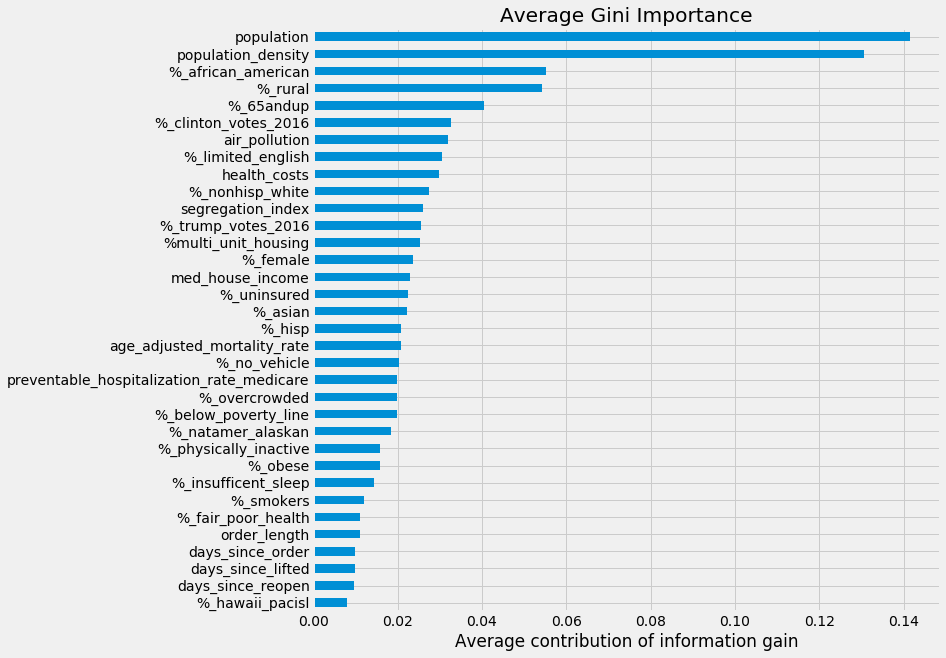

In [175]:
feature_scores = pd.Series(rfc.feature_importances_, index=X.columns)
feature_scores = feature_scores.sort_values()

ax = feature_scores.plot(kind='barh', figsize=(10,10))
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution of information gain')

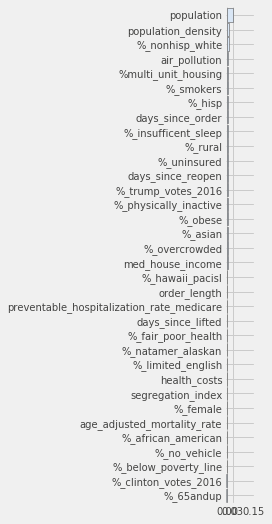

In [176]:
imp = importances(rfc, X_test, y_test, n_samples=-1)
viz = plot_importances(imp)
viz.view()

In [177]:
confusion_matrix(y_test, rfc.predict(X_test))

array([[367,  71],
       [119, 229]])

In [178]:
precision_score(y_test, rfc.predict(X_test))

0.7633333333333333

In [179]:
recall_score(y_test, rfc.predict(X_test))

0.6580459770114943

In [180]:
estimator_list = [50, 75, 100, 125, 150, 175, 200]
score_list = []
for i in estimator_list:
    rfc1 = RandomForestClassifier(n_estimators=i, oob_score=True)
    rfc1.fit(X_train, y_train)
    score_list.append(rfc1.score(X_test, y_test))
estimator_scores = dict(zip(estimator_list, score_list))
estimator_scores

{50: 0.7582697201017812,
 75: 0.7595419847328244,
 100: 0.7506361323155216,
 125: 0.7620865139949109,
 150: 0.7569974554707379,
 175: 0.7582697201017812,
 200: 0.7646310432569975}

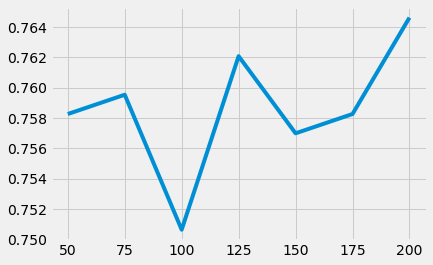

In [181]:
x = estimator_list
y = score_list
fig, ax = plt.subplots()
ax.plot(x,y)

In [182]:
max_features = []
score_list = []
for i in range(1, len(X.columns)):
    rfc2 = RandomForestClassifier(max_features=i, oob_score=True)
    rfc2.fit(X_train, y_train)
    score_list.append(rfc2.score(X_test, y_test))
    max_features.append(i)
feature_scores = dict(zip(max_features, score_list))
feature_scores

{1: 0.772264631043257,
 2: 0.7608142493638677,
 3: 0.7531806615776081,
 4: 0.7608142493638677,
 5: 0.7569974554707379,
 6: 0.7633587786259542,
 7: 0.7633587786259542,
 8: 0.7569974554707379,
 9: 0.7569974554707379,
 10: 0.7569974554707379,
 11: 0.7544529262086515,
 12: 0.7455470737913485,
 13: 0.7480916030534351,
 14: 0.7646310432569975,
 15: 0.7493638676844784,
 16: 0.7468193384223919,
 17: 0.7519083969465649,
 18: 0.7468193384223919,
 19: 0.7519083969465649,
 20: 0.7582697201017812,
 21: 0.7506361323155216,
 22: 0.7519083969465649,
 23: 0.7531806615776081,
 24: 0.7557251908396947,
 25: 0.7493638676844784,
 26: 0.7493638676844784,
 27: 0.7442748091603053,
 28: 0.7455470737913485,
 29: 0.7569974554707379,
 30: 0.7620865139949109,
 31: 0.7531806615776081,
 32: 0.7480916030534351,
 33: 0.7493638676844784}